# DataCamp Certification Case Study

### Project Brief

You are on the data science team for a coffee company that is looking to expand their business into Ukraine. They want to get an understanding of the existing coffee shop market there.

You have a dataset from Google businesses. It contains information about coffee shops in Ukraine. The marketing manager wants to identify the key coffee shop segments. They will use this to construct their marketing plan. In their current location, they split the market into 5 segments. The marketing manager wants to know how many segments are in this new market, and their key features.

You will be presenting your findings to the Marketing Manager, who has no data science background.

The data you will use for this analysis can be accessed here: `"data/coffee_shops.csv"`

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta
from scipy import stats
from scipy.stats import norm, skew
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import fcluster,linkage, dendrogram
from sklearn.feature_selection import SelectFromModel
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set graph style and font
sns.set()
# Change the axes' title and label size to 18 & 16 by default and default figure size, and make title bold
# Axes formatter limit will only display scientific notation if it's > 10^7 or < 10^-5
plt.rcParams.update({'axes.titleweight': 'bold','figure.figsize': (8,8),'axes.titlesize': 18,'axes.labelsize': 16, 
                     'legend.fontsize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'font.family': 'serif', 
                     'axes.formatter.limits':'-5, 7'}) 

# 📖 Background
A coffee company wants to expand their business to the Ukraine market.Using existing market data, I will guide them through the necessary steps that they should take in order to have a successful market entry, based upon critical business insights and market knowledge. I will also analyze and dissect the data to see what types of market segments are there in the Ukraine market.

## Analysis plan


We'll have these main sections for this notebook:
1. Cleaning data
2. Exploratory data analysis
3. Clustering
4. Conclusion and recommendations

## Existing data
We're given a dataset of 200 shops of different types, we'll first look at the dataset. 

In [3]:
current_path = os.getcwd()
shops = pd.read_csv(current_path + '/coffee_shops.csv') 
shops.head()

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,Mariupol,Dim Kavu,Coffee store,4.6,206.0,NaN,NaN,NaN,NaN
1,Mariupol,Коферум,Cafe,5.0,24.0,$$,False,NaN,True
2,Mariupol,Кофейня Світ Чаю,Coffee shop,5.0,11.0,NaN,NaN,NaN,True
3,Mariupol,Кофейня Starcoff,Coffee shop,4.4,331.0,$$,False,True,True
4,Mariupol,"Кофейня ""Friend Zone""",Coffee shop,5.0,12.0,NaN,NaN,True,True


In [4]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Region           200 non-null    object 
 1   Place name       200 non-null    object 
 2   Place type       200 non-null    object 
 3   Rating           198 non-null    float64
 4   Reviews          198 non-null    float64
 5   Price            122 non-null    object 
 6   Delivery option  129 non-null    object 
 7   Dine in option   140 non-null    object 
 8   Takeout option   144 non-null    object 
dtypes: float64(2), object(7)
memory usage: 14.2+ KB


In [5]:
shops.describe(include = 'all')

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
count,200,200,200,198.000000,198.000000,122,129,140,144
unique,10,187,14,NaN,NaN,3,2,1,1
top,Mariupol,Dim Kavy,Coffee shop,NaN,NaN,$$,False,True,True
freq,20,4,97,NaN,NaN,116,94,140,144
mean,NaN,NaN,NaN,4.663636,622.494949,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,0.221648,1400.898666,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,3.900000,3.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,4.600000,47.500000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,4.700000,271.500000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,4.800000,786.250000,NaN,NaN,NaN,NaN


Explanations of variables:
- Region: one of 10 possible regions where coffee shop is located
- Place name: name of the shop
- Place type: the type of coffee shop (e.g., “Cafe”, “Espresso Bar”...)
- Rating: coffee shop rating (on a 5-point scale)
- Reviews: number of reviews provided for the shop
- Price: price category (e.g., \\$, \\$$), the more \\$ a shop has, the more expensive it is
- Delivery option: whether there is (or isn’t) a delivery option
- Dine-in option: describing whether there is or isn’t (missing) a dine-in option
- Takeout option: describing whether there is or isn’t (missing) a takeout option

# Clean data
First, we'll proceed with some cleaning of the data

In [6]:
# See the missing data
shops.isna().sum()

Region              0
Place name          0
Place type          0
Rating              2
Reviews             2
Price              78
Delivery option    71
Dine in option     60
Takeout option     56
dtype: int64

First we'll drop the 2 shops without rating and reviews as we cannot reliably judge how good the service of that shop is without any information

In [7]:
shops.dropna(axis = 0, subset = ['Rating','Reviews'], inplace = True)

We'll fill in the missing data with relevant values for these 3 columns next: false values for dine-in, and takeout options where there's a missing values, and 'unknown' or '2' for delivery option where there's missing data.

In [8]:
shops[['Dine in option', 'Takeout option']] = shops[['Dine in option', 'Takeout option']].fillna(0, axis = 0)
shops['Delivery option'] = shops['Delivery option'].fillna(2, axis = 0)
shops.head()

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,Mariupol,Dim Kavu,Coffee store,4.6,206.0,NaN,2,0,0
1,Mariupol,Коферум,Cafe,5.0,24.0,$$,False,0,True
2,Mariupol,Кофейня Світ Чаю,Coffee shop,5.0,11.0,NaN,2,0,True
3,Mariupol,Кофейня Starcoff,Coffee shop,4.4,331.0,$$,False,True,True
4,Mariupol,"Кофейня ""Friend Zone""",Coffee shop,5.0,12.0,NaN,2,True,True


For price values, we'll have to guesstimate how expensive these places are by using clustering to help us infer the data later.

Next we'll transform False values -> 0, and True values -> 1 in these 3 columns. But first we'll have to convert these values to boolean types.

In [9]:
shops[['Delivery option', 'Dine in option', 'Takeout option']].replace({'True': True,'False':False})
shops[['Delivery option', 'Dine in option', 'Takeout option']] = shops[['Delivery option', 'Dine in option', 'Takeout option']] * 1
shops.head()

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,Mariupol,Dim Kavu,Coffee store,4.6,206.0,NaN,2,0,0
1,Mariupol,Коферум,Cafe,5.0,24.0,$$,0,0,1
2,Mariupol,Кофейня Світ Чаю,Coffee shop,5.0,11.0,NaN,2,0,1
3,Mariupol,Кофейня Starcoff,Coffee shop,4.4,331.0,$$,0,1,1
4,Mariupol,"Кофейня ""Friend Zone""",Coffee shop,5.0,12.0,NaN,2,1,1


In [10]:
# See which types of places there are
shops['Place type'].unique()

array(['Coffee store', 'Cafe', 'Coffee shop', 'Espresso bar',
       'Chocolate shop', 'European restaurant', 'Internet shop',
       'Appliance repair service', 'Store', 'Coffee stand',
       'Coffee roasters', 'Pastry shop', 'E-commerce service',
       'Restaurant'], dtype=object)

Since 'Appliance repair service' doesn't seem to have anything in common with a coffee shop, we'll drop those stores.

In [11]:
# Get indexes for which column Place type has value 'Appliance repair service'
indices = shops[shops['Place type'] == 'Appliance repair service'].index
# Delete these row indexes from shops
shops.drop(indices, inplace=True)
shops.shape

(197, 9)

In [12]:
# Check the current price points distribution
shops['Price'].value_counts()

$$     116
$$$      4
$        2
Name: Price, dtype: int64

It seems that most places have same price range of \\$\\$ (mid-range), we'll look at the places with \\$\\$\\$ and \\$ below.

In [13]:
print('Upscale shops are:\n', shops[shops['Price'] == '$$$'])
print('\n Affordable shops are:\n', shops[shops['Price'] == '$'])

Upscale shops are:
           Region                    Place name   Place type  Rating  Reviews  \
26       Poltava                        KOFEiN         Cafe     4.4    860.0   
130  Khrivoy Rog                   ЕТУАЛЬ КАФЕ         Cafe     4.6    327.0   
180       Dnipro  DoubleDecker Cake and Coffee  Pastry shop     4.7   2381.0   
195       Dnipro                        Artist   Restaurant     4.6    963.0   

    Price Delivery option Dine in option Takeout option  
26    $$$               2              1              1  
130   $$$               1              1              1  
180   $$$               1              1              1  
195   $$$               2              1              1  

 Affordable shops are:
        Region             Place name    Place type  Rating  Reviews Price  \
13   Mariupol  Кафе на Георгіївській          Cafe     4.5    806.0     $   
158      Kiev          Espressoholic  Espresso bar     4.6   1300.0     $   

    Delivery option Dine in opti

There's no clear trend as to what types of shops are upscale or affordable yet, due to the small amount of data. We'll leave Price data as-is for now, and will come back to this after clustering.

# Exploratory Data Analysis

## Univariate analysis
We will see the distribution of each of the variables in the dataset, except Price

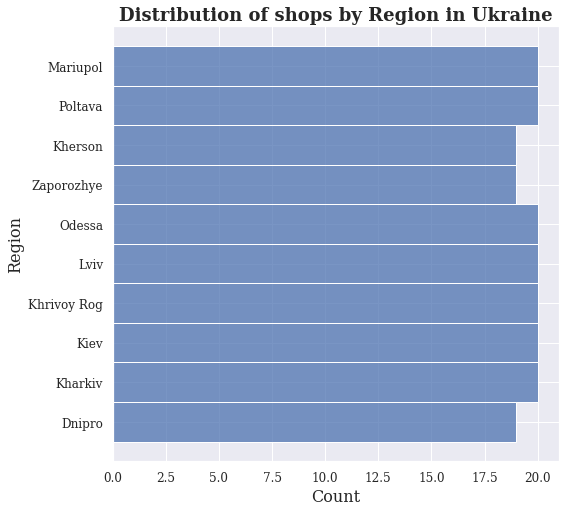

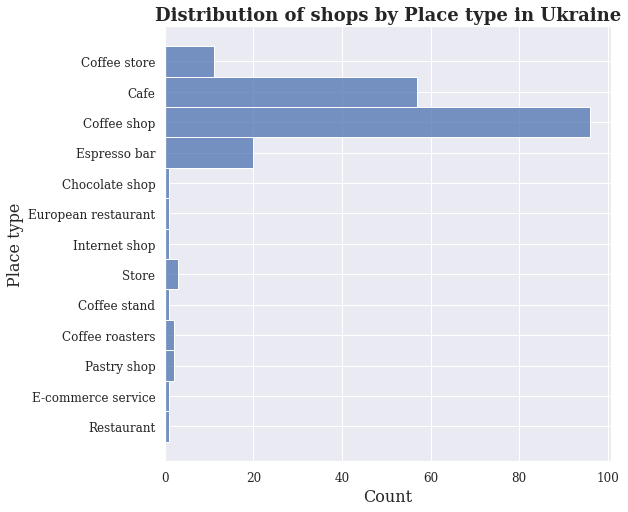

In [14]:
numeric_columns = ['Rating','Reviews', 'Delivery option', 'Dine in option', 'Takeout option']
non_numeric_columns = ['Region', 'Place type']
for column in non_numeric_columns: 
    sns.histplot(data = shops, y = column)
    plt.title('Distribution of shops by ' + str(column) + ' in Ukraine')
    plt.show()

The number of shops seem to be equally distributed among all 10 regions in Ukraine, thus so far we cannot really say whether a certain region will bring in more revenues or not just from the number of shops. 

Regarding the types of places, the majority of places are coffee-oriented shops: "coffee shop", "coffee store", "cafes", and "espresso bar." Most of the other categories of places are quite small in terms of number.

Next, we'll look at numeric columns to see what the information can tell us

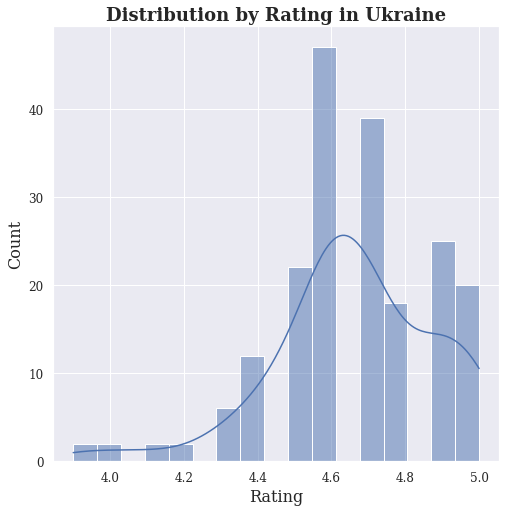

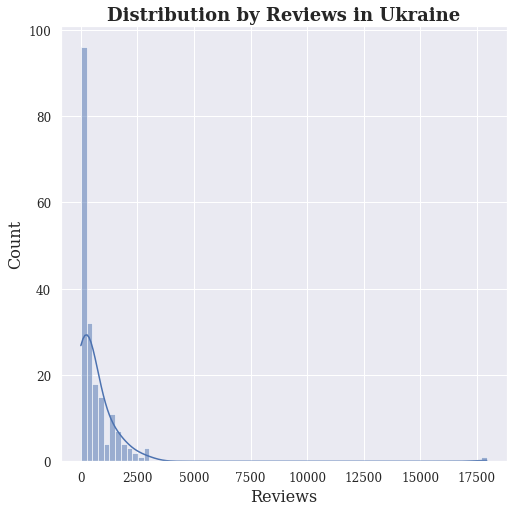

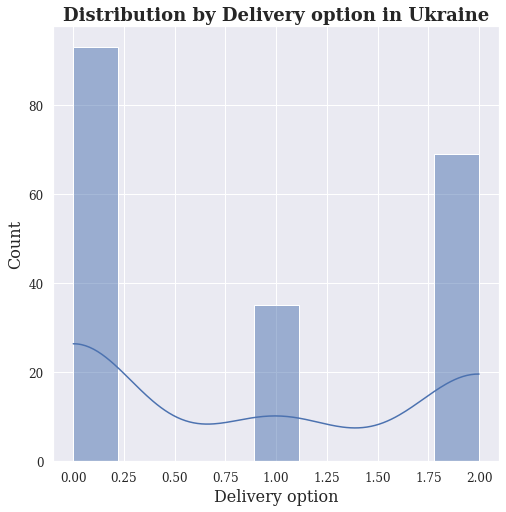

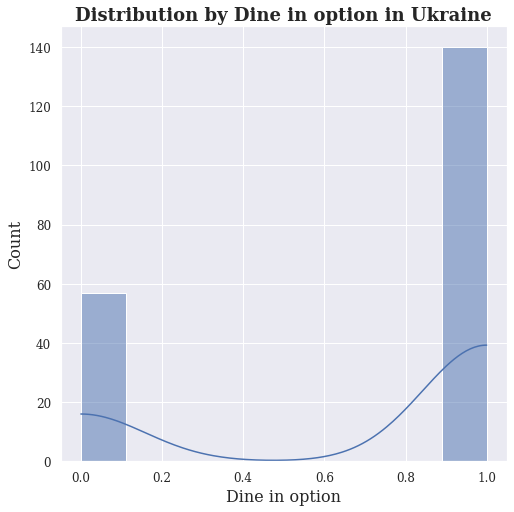

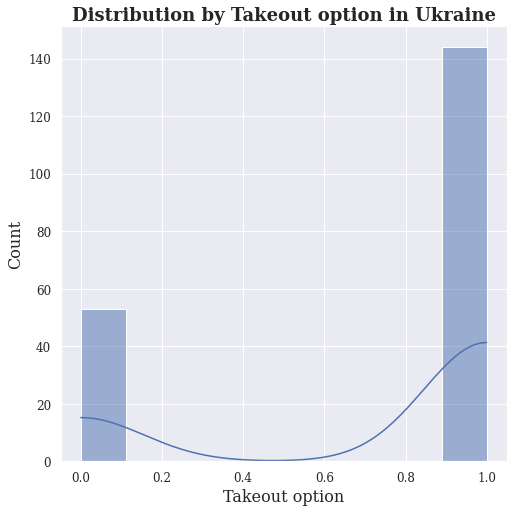

In [15]:
# We'll see the variables in the numeric columns
for column in numeric_columns: 
    sns.histplot(shops[column], kde = True)
    plt.title('Distribution by ' + str(column) + ' in Ukraine')
    plt.show()

In [16]:
print('The average shop rating is', shops['Rating'].mean())
print('The average number of reviews a shop has is', shops['Reviews'].mean())

The average shop rating is 4.661928934010156
The average number of reviews a shop has is 625.5786802030457


Looking at the graphs and the statistics, we can see that:
- Coffee shops seem to have very good ratings, the average is 4.66, thus high-quality customer service is a must.
- The average number of reviews a shop has is 625, signifying that most of these places are well-established, even if we assume a review rate of 1-2 reviews/day, it'd still take at least 1-2 years to get to the average number of reviews. Reviews are important because they help to: instill trust in customers, having a direct line from customers (get feedback to improve service), and also to help our shop appear higher in search engine rankings.
- The majority of shops (45%) do not offer delivery option, 35% offer delivery, and the rest 25% we do not know whether they actually offer delivery option or not. Thus this may not be a necessary service that we need to offer.
- As expected, the majority of shops offer dine-in option. After all, it's a coffee shop that we're looking at, where people go to hang out, do their homework, or to relax.
- Takeout option seems to be favored by the majority of restaurants, thus it's also a necessary service that we need to offer.
- Under rating, we see that there's a huge outlier with over 17,000 reviews, we'll proceed to examine this outlier further.

In [17]:
# See the outlier
# times 3 below because the empirical rule states that 99.7% of data observed following a normal distribution lies within 3 standard deviations of the mean. 
high_review = shops['Reviews'].mean() + shops['Reviews'].std()*3 
shops[shops['Reviews'] > high_review]

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
100,Lviv,Lviv Coffee Manufacture,Coffee shop,4.7,17937.0,$$,1,1,1


Since this place is a coffee manufacture with very high reviews, we'll proceed to drop this, otherwise it may skew our clustering results later on.

In [18]:
# We'll just drop the outlier by the index
shops = shops.drop(100, axis = 0)
# Reset index after dropping
shops = shops.reset_index(drop=True)
shops.shape

(196, 9)

## Multivariate analysis
We will see how each of these variables interact with one another

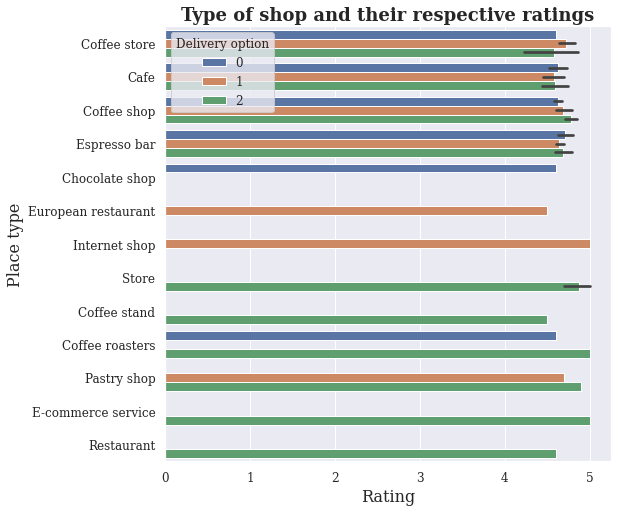

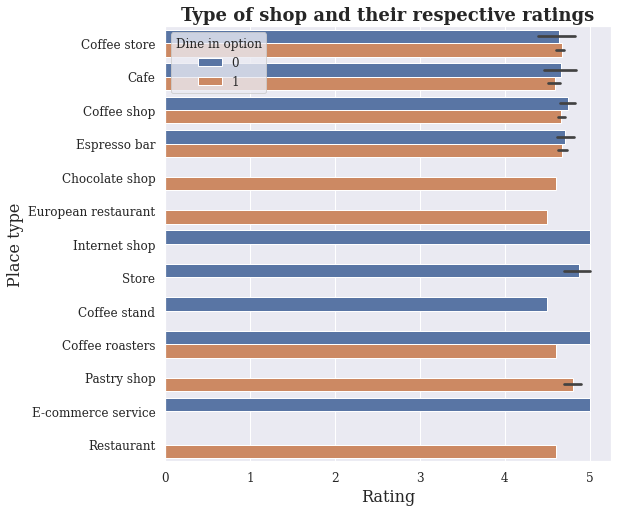

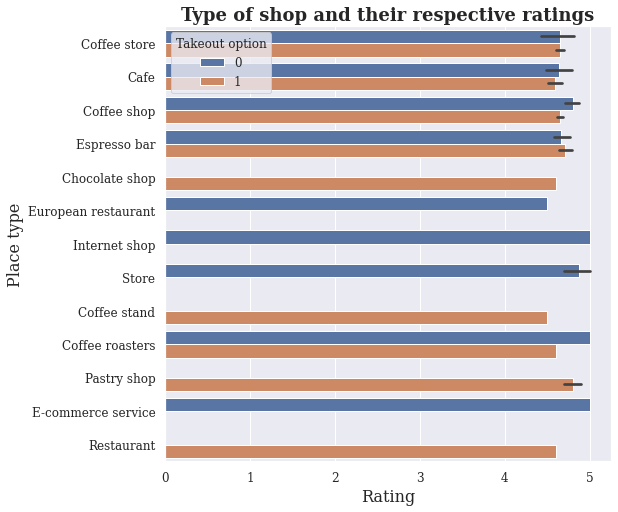

In [19]:
option_columns = ['Delivery option', 'Dine in option', 'Takeout option']
# Types of shops and the ratings
for column in option_columns:
    sns.barplot(x = 'Rating', y = 'Place type', hue = column, data = shops)
    plt.title('Type of shop and their respective ratings')
    plt.show()

Some types of shops only offer takeout options, which make sense. In general, for a store of the same type, ratings tend to be higher for places that don't offer takeout option, but not by much, thus it's quite hard to gauge from the rating metric alone.

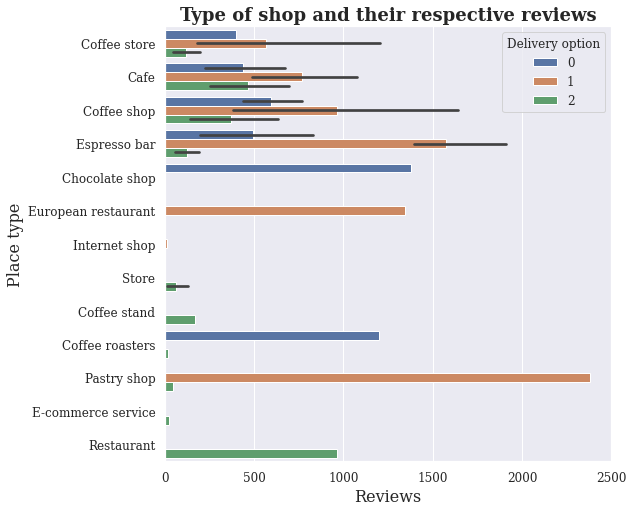

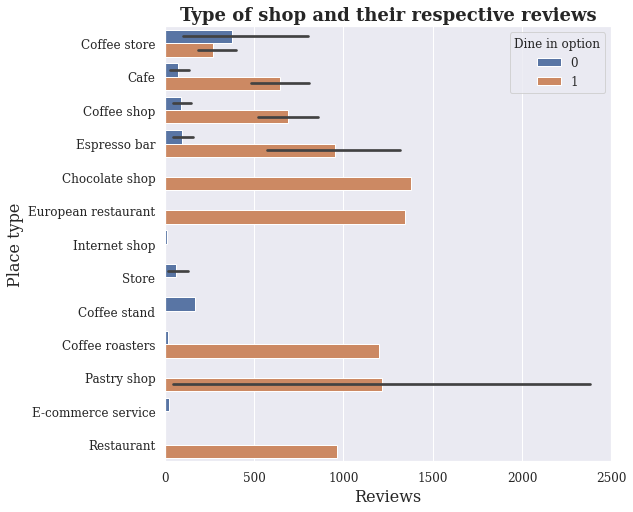

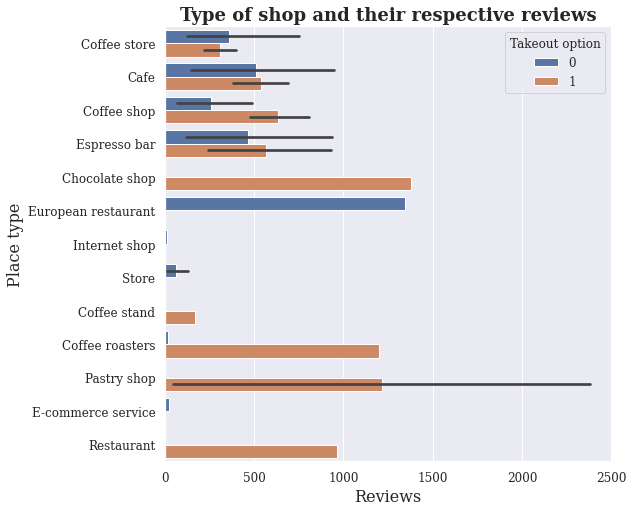

In [20]:
# Types of shops and the number of reviews
for column in option_columns:
    sns.barplot(x = 'Reviews', y = 'Place type', hue = column, data = shops)
    plt.title('Type of shop and their respective reviews')
    plt.show()

By far, places that offer dinein option and/or takeout option tend to have so many more reviews vs. their counterparts that do not offer these options. What we can conclude from this is that these extra options (dinein and takeout) are not only optional, but they're a must if we want to obtain more reviews, which we already ascertained that reviews are critical nowadays. Not to mention that we are still living the Covid-19 era, thus having the ability to takeout is definitely a necessity these days so that customers can feel safer.

The same also applies for delivery option, but only for the main types of coffee stores: "Espresso bar", "Cafe", "Coffee shop", "Coffee store"

Next we'll see which region tends to have the best ratings and reviews

In [21]:
# We'll group by the main numeric columns: Rating and Reviews
regions = shops.groupby('Region')[numeric_columns].mean().round(2)
regions

,Rating,Reviews
Region,,
Dnipro,4.55,589.95
Kharkiv,4.58,544.45
Kherson,4.64,370.16
Khrivoy Rog,4.60,461.90
Kiev,4.78,764.60
Lviv,4.67,1096.63
Mariupol,4.70,193.80
Odessa,4.78,422.00
Poltava,4.65,535.25


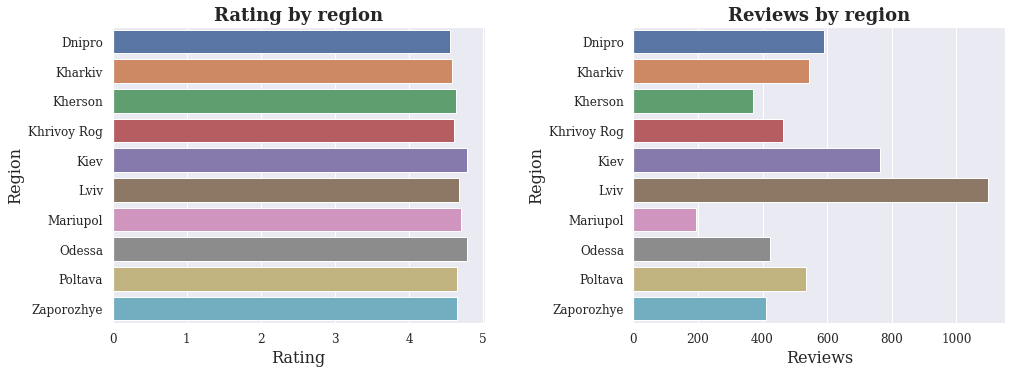

In [22]:
# Put the numbers above into graphs
plt.figure(figsize = (16,12))
plt.subplots_adjust(wspace = 0.4)
for i, column in enumerate(regions.columns.to_list()):
    plt.subplot(2, 2, i+1)
    sns.barplot(x = regions[column], y = regions.index)
    plt.title(column + ' by region')
plt.show()

From a business standpoint, we would want to establish a shop in a region where there's not many reviews yet, because it means that the time needed to "catch up" (in terms of number of reviews) and establish our own shop would be shorter. Furthermore, if a region has lower rating, then it's also means that there's inefficiency in terms of customer service, order speed, etc., and we can take advantage of this by offering some improvement, such as better customer service, faster delivery time, more environmentally-friendly options such as no plastic straw. We would have to look through some real customer reviews (not included in this dataset) from those regions to understand the trend, and then extract out what things we can do better. 

With these criteria in mind, the 3 most promising regions to establish a shop in would be:
- Mariupul with only 194 reviews and an average rating of 4.7
- Kherson at 370 reviews and an average rating of 4.64
- Zaporozhye with 409 reviews and an average rating of 4.65

# Clustering
Next we'll look at how to group these shops together using machine learning and also attempt to figure out the price point

In [23]:
# Create a new dataset composed of just rating and reviews for clustering
X = shops[['Rating', 'Reviews']]
X

,Rating,Reviews
0,4.6,206.0
1,5.0,24.0
2,5.0,11.0
3,4.4,331.0
4,5.0,12.0
...,...,...
191,4.6,963.0
192,4.3,646.0
193,4.6,16.0
194,4.7,599.0


In [24]:
# We will scale the data for the rating and review columns since they're quite skewed as we saw in the graphs
scaler = StandardScaler()
X[['Scaled rating', 'Scaled reviews']] = scaler.fit_transform(X)
print(X)

     Rating  Reviews  Scaled rating  Scaled reviews
0       4.6    206.0      -0.279486       -0.502925
1       5.0     24.0       1.531398       -0.779244
2       5.0     11.0       1.531398       -0.798981
3       4.4    331.0      -1.184928       -0.313145
4       5.0     12.0       1.531398       -0.797463
..      ...      ...            ...             ...
191     4.6    963.0      -0.279486        0.646383
192     4.3    646.0      -1.637649        0.165101
193     4.6     16.0      -0.279486       -0.791390
194     4.7    599.0       0.173235        0.093744
195     4.3    341.0      -1.637649       -0.297962

[196 rows x 4 columns]


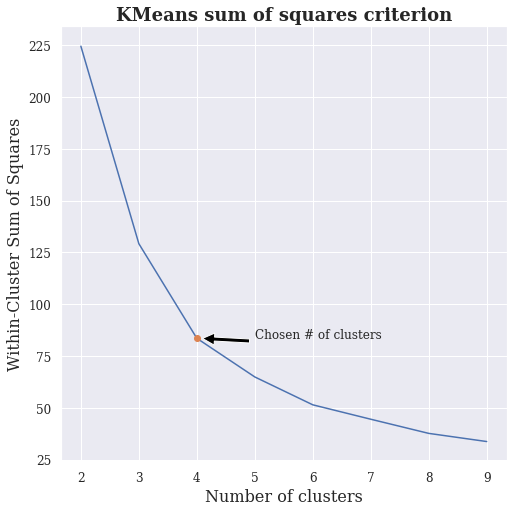

In [25]:
# To keep track of the within-cluster sum of squares
scores = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(X[['Scaled rating', 'Scaled reviews']])
    scores.append(kmeans.inertia_)

# Plot Within-Cluster Sum of Squares distance
fig, ax = plt.subplots()
plt.plot(np.arange(2,10), scores)
plt.title('KMeans sum of squares criterion')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Squares')
ax.annotate('Chosen # of clusters', xy=(4.05, 83.58), xytext=(5, 83.58),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.plot(4, 83.58, 'o')  # Plot a small dot inside the graph
plt.show()

Using the elbow method, we can see that the most appropriate number of clusters would be 4. Now we proceed to label the data with these new clusters

In [26]:
# Get the labels for 4 clusters
np.random.seed(2) # To ensure replicability
kmeans = KMeans(n_clusters = 4)
kmeans.fit(X)
group_labels = kmeans.labels_

In [27]:
# Append the group labels into the original data
clustered_shops = shops.assign(Cluster = group_labels)
print(clustered_shops.head())

# See how many shops are in each cluster
print('Number of shops in each cluster is:\n', clustered_shops.groupby('Cluster')['Region'].count())

# Group clusters by rating and reviews
clustered_shops.groupby('Cluster')[['Rating', 'Reviews']].mean().round(2)

     Region             Place name    Place type  Rating  Reviews Price  \
0  Mariupol               Dim Kavu  Coffee store     4.6    206.0   NaN   
1  Mariupol                Коферум          Cafe     5.0     24.0    $$   
2  Mariupol       Кофейня Світ Чаю   Coffee shop     5.0     11.0   NaN   
3  Mariupol       Кофейня Starcoff   Coffee shop     4.4    331.0    $$   
4  Mariupol  Кофейня "Friend Zone"   Coffee shop     5.0     12.0   NaN   

  Delivery option Dine in option Takeout option  Cluster  
0               2              0              0        0  
1               0              0              1        0  
2               2              0              1        0  
3               0              1              1        0  
4               2              1              1        0  
Number of shops in each cluster is:
 Cluster
0    122
1     24
2     40
3     10
Name: Region, dtype: int64


,Rating,Reviews
Cluster,,
0,4.71,135.28
1,4.56,1497.04
2,4.58,706.80
3,4.64,2459.70


We can see that cluster 0 has the most number of shops, at 122, and also with the highest rating at 4.7. However, they have the fewest number of reviews.
Cluster 3 has the most number of reviews at 2459 and an average rating of 4.64.
If we need to categorize these cluster into market segments, then it'd be like the following: 
- Segment 1 (cluster 0): highest rating with few reviews.
- Segment 2 (cluster 1): lowest rating with high number of reviews.
- Segment 3 (cluster 2): medium rating with just slightly more than the average number of reviews nationwide.
- Segment 4 (cluster 3): medium rating with the most number of reviews.

Again, from a business standpoint, cluster 0 seems to be the least competitive for us to enter the coffee shop market due to the low number of reviews.Thus we'll take a look further into this cluster.

Before that, we'll quickly look at pricing from clustered shops

In [28]:
# Upscale shops
clustered_shops[clustered_shops['Price'] == '$$$']

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option,Cluster
26,Poltava,KOFEiN,Cafe,4.4,860.0,$$$,2,1,1,2
127,Khrivoy Rog,ЕТУАЛЬ КАФЕ,Cafe,4.6,327.0,$$$,1,1,1,0
177,Dnipro,DoubleDecker Cake and Coffee,Pastry shop,4.7,2381.0,$$$,1,1,1,3
191,Dnipro,Artist,Restaurant,4.6,963.0,$$$,2,1,1,2


Pricing-wise, it seems that cluster 2 has the most number of upscale shops, followed by cluster 3 and 0. 

In [29]:
# Affordable shops
clustered_shops[clustered_shops['Price'] == '$']

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option,Cluster
13,Mariupol,Кафе на Георгіївській,Cafe,4.5,806.0,$,2,1,1,2
155,Kiev,Espressoholic,Espresso bar,4.6,1300.0,$,0,1,1,1


The 2 affordable shops are in cluster 2 and 1 respectively. 

After all, pricing is something that we still cannot rely on yet due to lack of data even after clustering. Thus the only safe bet when it comes to pricing is to be competitive, thus price in the mid-price range \\$\\$ is likely to be the most appropriate.

In [30]:
cluster_0 = clustered_shops[clustered_shops['Cluster'] == 0]
cluster_0

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option,Cluster
0,Mariupol,Dim Kavu,Coffee store,4.6,206.0,NaN,2,0,0,0
1,Mariupol,Коферум,Cafe,5.0,24.0,$$,0,0,1,0
2,Mariupol,Кофейня Світ Чаю,Coffee shop,5.0,11.0,NaN,2,0,1,0
3,Mariupol,Кофейня Starcoff,Coffee shop,4.4,331.0,$$,0,1,1,0
4,Mariupol,"Кофейня ""Friend Zone""",Coffee shop,5.0,12.0,NaN,2,1,1,0
...,...,...,...,...,...,...,...,...,...,...
186,Dnipro,"""Франс.уа"" кофейня-пекарня",Cafe,3.9,9.0,NaN,0,0,1,0
187,Dnipro,Tsikava Kava,Coffee store,4.7,185.0,NaN,1,1,0,0
190,Dnipro,Колибри,Cafe,5.0,18.0,NaN,2,1,1,0
193,Dnipro,РУТА КАФЕ ПП КУЛІЧЕНКО К.І.,Cafe,4.6,16.0,$$,0,1,1,0


We'll plot the data in this clusters and see

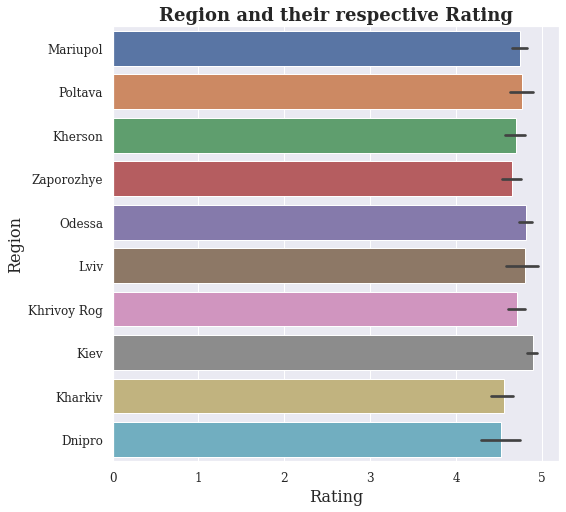

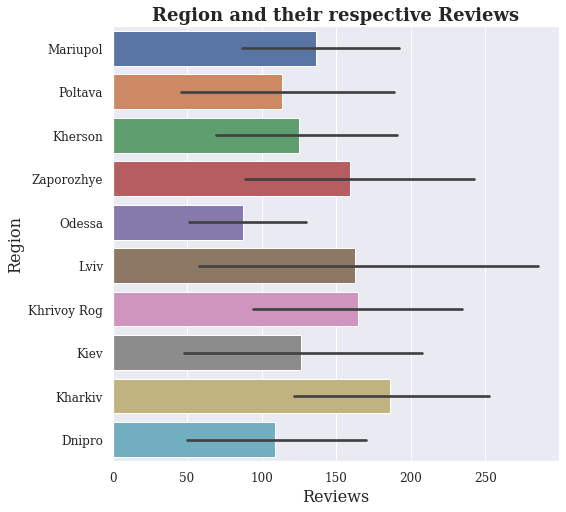

In [31]:
metric_columns = ['Rating', 'Reviews']
# Ratings and reviews by region
for column in metric_columns:
    sns.barplot(y = 'Region', x = column, data = cluster_0)
    plt.title('Region and their respective ' + column)
    plt.show()

Odessa and Dnipro in cluster 0 stand out as the areas with the least reviews. Dnipro also happens to have the lowest rating among the 10 regions.

We'll also quickly look at the number of shops in each of these regions in cluster 0

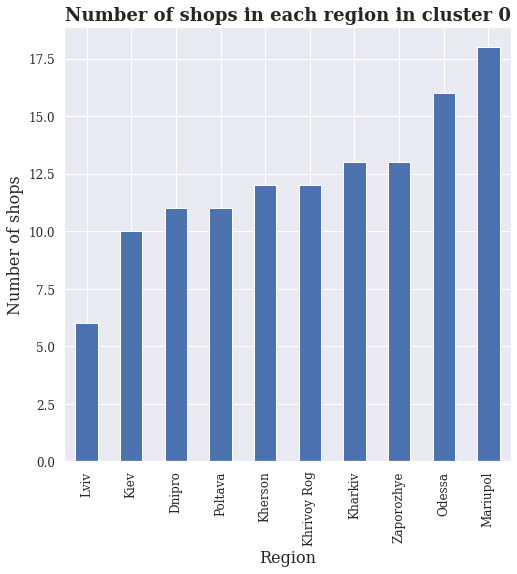

In [32]:
cluster_0.groupby('Region')['Rating'].count().sort_values().plot(kind = 'bar')
plt.ylabel('Number of shops')
plt.xlabel('Region')
plt.title('Number of shops in each region in cluster 0')
plt.show()

Odessa has 16 shops already in cluster 0, whereas Poltava and Dnipro have 11 shops each.  

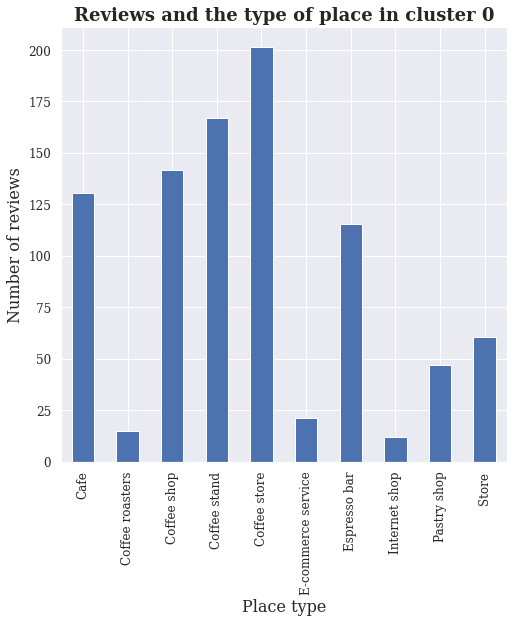

In [33]:
cluster_0.groupby('Place type')['Reviews'].mean().plot(kind = 'bar')
plt.ylabel('Number of reviews')
plt.xlabel('Place type')
plt.title('Reviews and the type of place in cluster 0')
plt.show()

Coffee-style places have the most number of reviews in cluster 0.

Earlier we identify that shops should offer both dinein and takeout options to be competitive. Now we will check to see the proportions of shops that offer these extra services in each of the cluster. We'll check the proportion that offer delivery afterwards.

In [34]:
# Get this number in cluser 0
dinein = cluster_0['Dine in option'] == True
takeout = cluster_0['Takeout option'] == True

two_services_0 = cluster_0[dinein & takeout]
proportion_0 = len(two_services_0) / len(cluster_0)

In [35]:
cluster_1 = clustered_shops[clustered_shops['Cluster'] == 1]
cluster_2 = clustered_shops[clustered_shops['Cluster'] == 2]
cluster_3 = clustered_shops[clustered_shops['Cluster'] == 3]

In [36]:
# Get this number in cluser 1
dinein = cluster_1['Dine in option'] == True
takeout = cluster_1['Takeout option'] == True

two_services_1 = cluster_1[dinein & takeout]
proportion_1 = len(two_services_1) / len(cluster_1)

In [37]:
# Get this number in cluser 2
dinein = cluster_2['Dine in option'] == True
takeout = cluster_2['Takeout option'] == True

two_services_2 = cluster_2[dinein & takeout]
proportion_2 = len(two_services_2) / len(cluster_2)

In [38]:
# Get this number in cluser 3
dinein = cluster_3['Dine in option'] == True
takeout = cluster_3['Takeout option'] == True

two_services_3 = cluster_3[dinein & takeout]
proportion_3 = len(two_services_3) / len(cluster_3)

In [39]:
t1 = PrettyTable()
t1.field_names = ["Cluster", "Percentage of shops that offer both dine-in and take-out"]
t1.add_rows([        
        ["Cluster 0", '{:.1%}'.format(proportion_0)],
        ["Cluster 1", '{:.1%}'.format(proportion_1)],
        ["Cluster 2", '{:.1%}'.format(proportion_2)],
        ["Cluster 3", '{:.1%}'.format(proportion_3)],
])
print(t1)

+-----------+----------------------------------------------------------+
|  Cluster  | Percentage of shops that offer both dine-in and take-out |
+-----------+----------------------------------------------------------+
| Cluster 0 |                          45.9%                           |
| Cluster 1 |                          66.7%                           |
| Cluster 2 |                          92.5%                           |
| Cluster 3 |                          100.0%                          |
+-----------+----------------------------------------------------------+


As we can see, cluster 3 seems to be the most advanced as all shops offer both options, whereas in cluster 0 there's only 45.9% of shops that offer both dine-in and take-out options.

Now we'll check the percentages of shops that offer delivery in each cluster

In [40]:
delivery_in_0 = cluster_0['Delivery option'] == True
delivery_0 = cluster_0[delivery_in_0]
prop_deliver_0 = len(delivery_0) / len(cluster_0)

delivery_in_1 = cluster_1['Delivery option'] == True
delivery_1 = cluster_1[delivery_in_1]
prop_deliver_1 = len(delivery_1) / len(cluster_1)

delivery_in_2 = cluster_2['Delivery option'] == True
delivery_2 = cluster_2[delivery_in_2]
prop_deliver_2 = len(delivery_2) / len(cluster_2)

delivery_in_3 = cluster_3['Delivery option'] == True
delivery_3 = cluster_3[delivery_in_3]
prop_deliver_3 = len(delivery_3) / len(cluster_3)

In [41]:
t2 = PrettyTable()
t2.field_names = ["Cluster", "Percentage of shops that offer delivery"]
t2.add_rows([        
        ["Cluster 0", '{:.1%}'.format(prop_deliver_0)],
        ["Cluster 1", '{:.1%}'.format(prop_deliver_1)],
        ["Cluster 2", '{:.1%}'.format(prop_deliver_2)],
        ["Cluster 3", '{:.1%}'.format(prop_deliver_3)],
])
print(t2)

+-----------+-----------------------------------------+
|  Cluster  | Percentage of shops that offer delivery |
+-----------+-----------------------------------------+
| Cluster 0 |                  11.5%                  |
| Cluster 1 |                  50.0%                  |
| Cluster 2 |                  15.0%                  |
| Cluster 3 |                  20.0%                  |
+-----------+-----------------------------------------+


It seems that cluster 1 offers the most in terms of delivery, as 50% of the shops there offer this service. All other clusters barely offer any delivery services.

# Conclusion and recommendations

## 1. Market segments:
There're 4 market segments for coffee shops in Ukraine (extrapolating from this dataset). Overall, the prices in the market tend to be in the mid-price range \\$\\$. Overall, the markets' ratings for most shops in this dataset are quite high, thus even a tiny bit difference in customer service level or something unique may help a shop to stand out from its competitors.
- Segment 1 (cluster 0): highest rating with few reviews. There's a small amount of upscale shop. This segment has the least in terms of delivery option (at 11.5%), and dinein and take-out option, as only 45% of all restaurants offer that.
- Segment 2 (cluster 1): lowest rating with high number of reviews. There's no upscale shop, but there's small amount of affordable shops. Segment 2 has highest delivery offering rate at 50%, and 2/3 of shops in this cluster offer both dine-in and takeout options. 
- Segment 3 (cluster 2): medium rating with just slightly more than the average number of reviews nationwide. There are some upscale shops in this cluster. There's a very small amount of affordable shops. 15% of shops in this cluster offer delivery, and 92% of shops offer both dinein and takeout options.
- Segment 4 (cluster 3): medium rating with the most number of reviews. There's a small amount of upscale shop. All restaurants in this segment offer both dinein and takeout, but only 20% offer delivery option.

## 2. Market entry:
The best 3 regions to enter and open a new coffee shop would be: 
- Odessa
- Dnipro
- Poltava

Reasons why these 3 regions are attractive to open a new shop are:
- These regions' shops have low number of reviews, thus making easier for our company to establish our brand and "catch up" quickly.
- They lack a lot of options (delivery, dinein, and takeout), thus we should offer all three options: dinein, take-out, and delivery options so as to attract more customers by giving customers more flexibility in Covid-19 era.

The coffee shop that our company should open in Ukraine should have these characteristics: 
- Offer all 3 options: delivery, dinein, and takeout
- Prices should be in the mid-range so as to appeal to the masses
- Location in one of the 3 regions above
- Initially, we should offer some incentives for customers to write reviews for our shops such as "10% for your next purchase if you write us an honest review on Google business." 
- Type of shop should be either any of these: "Cafe", "Coffee shop", "Espresso bar", and "Coffee store." The other choices may not be suitable because they possibly cannot accommodate the 3 options: delivery, dinein, and takeout.